<center>
<h1>Usain Boltz : Uniform Sampling with Boltzmann method</h1>

<h2>Matthieu Dien (AMACCC, GREYC, UNICAEN)</h2>
<h2>Martin Pépin (APR, LIP6, Sorbonne Université)</h2>
</center>


# Principe

## Entrée

+ Une famille d'objet décrite par une *spécification combinatoire*, par exemple les arbres de Catalan : $$\mathcal{C} = \mathcal{Z} \times Seq(\mathcal{C})$$



+ La taille (exacte ou approximative) des objets que l'on souhaite générer c-à-d "le nombre de $\mathcal{Z}$"

## Sortie

+ Un objet de la bonne taille

In [1]:
from usainboltz import *

z = Atom()
C = RuleName()
grammar = Grammar({C : z * Seq(C)})
generator = Generator(grammar)

In [6]:
res = generator.sample((20,40))
res.obj

('z',
 [('z',
   [('z',
     [('z',
       [('z',
         [('z', []),
          ('z',
           [('z',
             [('z', []),
              ('z', [('z', [('z', [('z', []), ('z', [])])]), ('z', [])])])])]),
        ('z', [('z', []), ('z', []), ('z', []), ('z', [('z', [])])]),
        ('z', []),
        ('z', []),
        ('z', []),
        ('z', [])]),
      ('z', [])])])])

In [7]:
res.sizes[z]

26

__Définition *(construction admissible)*__ :

| Opérateurs                       | Interprétation "ensembliste"     | ```usainboltz.grammar``` |
|----------------------------------|----------------------------------|--------------------------|
| $\mathcal{E}$                    | Élément de taille $0$            | ```Epsilon()```
| $\mathcal{Z}$                    | Élément de taille $1$            | ```Atom()```
| $\mathcal{U}_i$                  | Des poids                        | ```Marker("U_i")```
| $\mathcal{A} + \mathcal{B}$      | Union disjointe                  | ```A + B```
| $\mathcal{A} \times \mathcal{B}$ | Produit cartésien                | ```A * B```
| $\mathcal{A} \star \mathcal{B}$  | Produit cartésien, bien étiqueté | ```A * B```
| $Seq\left(\mathcal{A}\right)$    | Suites d'éléments                | ```Seq(A)```
| $Set\left(\mathcal{A}\right)$    | Ensembles d'éléments             | ```Set(A)```

avec ```A, B = RuleName("A"), RuleName("B")```

# Le modèle de Boltzmann combinatoire (*Philippe Duchon, Philippe Flajolet, Guy Louchard, Gilles Schaeffer*)

Soit une classe combinatoire $\mathcal{A}$, un générateur de Boltzmann de paramètre $x$ pour $\mathcal{A}$
(noté $\Gamma\mathcal{A}(x)$) construit aléatoirement des objets $\gamma \in \mathcal{A}$ avec
la distribution suivante

$$
\mathbb{P}(\Gamma\mathcal{A}(x) = \gamma) = \frac{x^{|\gamma|}}{A(x)},
$$

où $A(x)$ est la *série génératrice* de $\mathcal{A}$ définie comme

$$
A(z) = \sum_{\gamma \in \mathcal{A}} z^{|\gamma|} = \sum_{n \geq 0} \sharp\mathcal{A}_n ~z^n
$$

### Propriétés remarquables :
$$
\begin{array}{l}
\Gamma [\mathcal{A}+\mathcal{B}](x) = \Gamma\mathcal{A}(x) ~~\text{avec proba}~~\frac{A(x)}{A(x)+B(x)}
~~\text{et}~~\Gamma\mathcal{B}(x)~~\text{sinon}\\
\\
\Gamma [\mathcal{A}\times\mathcal{B}](x) = (\Gamma\mathcal{A}(x), \Gamma\mathcal{B}(x))\\
\\
\Gamma[Seq\left(\mathcal{A}\right)] = [\Gamma\mathcal{A}(x), \dots, \Gamma\mathcal{A}(x)]
~~\text{de longueur}~~Geom\left(A(x)\right)\\
\\
\Gamma[Set\left(\mathcal{A}\right)] = \{\Gamma\mathcal{A}(x), \dots, \Gamma\mathcal{A}(x)\}
~~\text{de longueur}~~Poisson\left(A(x)\right)\\
\end{array}
$$

# Implémentation naïve

In [27]:
from random import seed

# Some random seed for reproducibility
seed(int(0x14cd7df7e50799d9))

In [28]:
from random import random as uniform

def gen_C(x):
    root_degree = 0
    while uniform() < x:
        root_degree += 1
    return ('z', [gen_C(x) for _ in range(root_degree)])

gen_C(0.5)

('z',
 [('z', []),
  ('z', []),
  ('z',
   [('z', []),
    ('z', [('z', []), ('z', [])]),
    ('z',
     [('z', [('z', [])]),
      ('z', [('z', []), ('z', [])]),
      ('z', []),
      ('z', [])])])])

# Les Oracles

+ non-singulier : $x$ solution de $n = x \cdot \frac{A'(x)}{A(x)}$

+ singulier : $x \simeq \rho_A$

+ __Paganini__ (Maciej Bendkowsky, Olivier Bodini, Sergey Dovgal)
  + utilise des solveurs (numériques) de problèmes convexes
  + implémenté en Python
  + [https://github.com/maciej-bendkowski/paganini](https://github.com/maciej-bendkowski/paganini)



+ __NewtonGF__ (Carine Pivoteau, Pablo Rotondo, Bruno Salvy)
  + utilise des généralisations de l'itération de Newton
  + implémenté en Maple
  + interface Python via Sagemath
  + [http://perso.ens-lyon.fr/bruno.salvy/software/the-newtongf-package/](http://perso.ens-lyon.fr/bruno.salvy/software/the-newtongf-package/)

#  Comment traduire spécification combinatoire en structure de données ?
### Martin Pépin à la rescousse

Exemples en utilisant Sagemath : [https://www.sagemath.org/](https://www.sagemath.org/)

In [10]:
from sage.combinat.ordered_tree import OrderedTree
from usainboltz.generator import rng_seed as ub_seed 

def C_builder(arg):
    root, children = arg
    return OrderedTree(children)

# Pour rappel : Grammar({C : z * Seq(C)})

ub_seed(0xdeadbeef)
generator.set_builder(C, C_builder)
ascii_art(generator.sample((10,10)))

(     o         , { z:10 } )
(     |                    )
(   __o____                )
(  /      /                )
( o   ___o_____            )
(    / /   /  /            )
(   o o   o_ o             )
(        / /               )
(       o o                )

In [11]:
from sage.combinat.binary_tree import BinaryTree

def C_as_btree_builder(arg):
    root, children = arg
    btree = None
    for child in children[::-1]:
        btree = BinaryTree([child[0],btree])
    return BinaryTree([btree, None])

ub_seed(0xdeadbeef)
generator.set_builder(C, C_as_btree_builder)
ascii_art(generator.sample((10,10)))

(      o   , { z:10 } )
(     /               )
(    o                )
(   /                 )
(  o                  )
(   \                 )
(    o                )
(   /                 )
( o                   )
(  \                  )
(    o                )
(     \               )
(     _o_             )
(    /   \            )
(   o     o           )
(    \                )
(     o               )

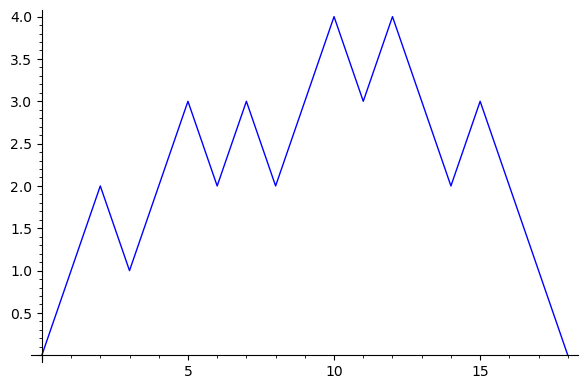

In [13]:
from sage.combinat.dyck_word import DyckWord

def C_as_dyckword_builder(arg):
    root, children = arg
    return "".join(["(" + child + ")" for child in children])       

ub_seed(0xdeadbeef)
generator.set_builder(C, C_as_dyckword_builder)
plot(DyckWord(generator.sample((10,10)).obj))

In [18]:
def C_as_height_builder(arg):
    root, children = arg
    return 0 if not children else 1 + max(children)

ub_seed(0xdeadbeef)
generator.set_builder(C, C_as_height_builder)
generator.sample((10,10))

Result(obj=4, sizes={z: 10})

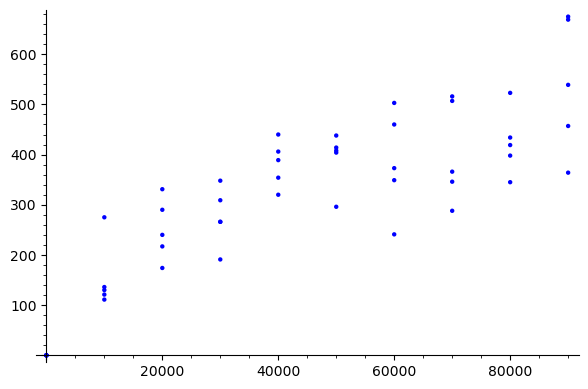

In [20]:
ub_seed(0xdeadbeef)
points(((i,generator.sample((0.9*i, 1.1*i)).obj) for i in range(1,100001,10000) for _ in range(5)))

# Implémentation


+ Libre (GPL) : [https://gitlab.com/ParComb/usain-boltz](https://gitlab.com/ParComb/usain-boltz)
  ou `pip install usain-boltz`
+ Langages : Python, Cython, C++
+ Interface en Python
+ Documentation et exemples : [https://usain-boltz.readthedocs.io/en/latest/](https://usain-boltz.readthedocs.io/en/latest/)

# Un autre exemple : les graphes distance-héréditaires

__Définition__ *(Bandet, Mulder et sans Scully)* : Un graphe construit à partir d'un noeud isolé et des règles suivantes

<center><img src="dh.svg" width="30%"></center>

<div style="text-align: right">(image : David Eppstein, Wikipedia)</div>

In [21]:
z = Atom()
Pendant, FTwins, TTwins = Marker("P"), Marker("F"), Marker("T")
inc_DH = RuleName()
grammar = Grammar({inc_DH : z**2 * Seq(z * Pendant + z * FTwins + z * TTwins)}, labelled=True)

In [22]:
from sage.graphs.graph import Graph

identity = lambda x : x

def inc_DH_builder(arg):
    _, _, seq = arg
    graph = Graph()
    lbl = 2
    graph.add_edge(1,2)
    for (_,vertex_type) in map(union_builder(identity, identity, identity), seq):
        lbl += 1
        u = graph.random_vertex()
        if vertex_type == "P":
            graph.add_edge(u, lbl)
        else:
            for v in graph.neighbor_iterator(u):
                graph.add_edge(v, lbl)
            if vertex_type == "T":
                graph.add_edge(u, lbl)
    return graph

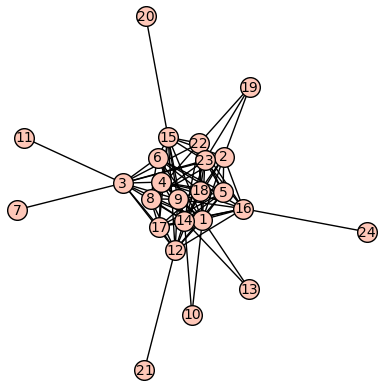

In [24]:
increasing_DH_gen = Generator(grammar, expectations={z:30, Pendant:10, FTwins:10})
increasing_DH_gen.set_builder(inc_DH, inc_DH_builder)

graph = increasing_DH_gen.sample((20,40)).obj
graph.show()

# TODO list

+ opérateurs de Pólya (structures non-étiquetées) : $PSet, Mset, Cycle$

+ opérateurs boîtes (structures ave étiquetages croissants)

+ pointage (et dérivation de grammaire)